# NISQ-Optimized Quantum Galton Board

Quantum Galton Boards have demonstrated theoretical promise as universal statistical simulators. However, to translate this promise into real-world utility, it's crucial to evaluate their resilience to noise on near-term hardware. This notebook focuses on simulating and optimizing the performance of the Quantum Galton Board (QGB) on NISQ-era devices. Building upon the general n-layer implementation, we examine how real-world noise impacts the practical implementation of QGBs under NISQ constraints by scaling the circuit layer-by-layer and analyzing the fidelity degradation between ideal and noisy simulations.

## Implementation Strategy

We implement and evaluate all three distribution cases—**Gaussian**, **exponential**, and **Hadamard walk** under both ideal and noisy conditions. The circuits are simulated using the `Qiskit AerSimulator`, with realistic noise models derived from IBM backends such as `FakeVigo`. The exponential distribution is constructed by replacing Hadamard gates with Rx(θ) rotations, while the Hadamard walk follows a quantum walk framework with coin and position qubits.

To quantify the effect of noise across increasing circuit depth, we systematically scale the number of layers and compare the output distributions using three fidelity metrics: **Wasserstein distance**, **Kullback-Leibler (KL) divergence**, and **Total Variation distance**. These statistical tools enable precise evaluation of how well the noisy outputs match the ideal distributions, helping us determine the optimal scaling limits for NISQ deployment.


## Aim

This analysis focuses on determining the scaling limits of the Quantum Galton Board under NISQ-era noise. A central goal is to identify the maximum number of layers that maintain statistical fidelity above a chosen threshold (typically 75%), beyond which quantum noise degrades performance significantly. Alongside this, we measure the impact of noise on statistical accuracy using fidelity metrics, while tracking how circuit depth and gate count scale with layer count. These results allow us to assess the feasibility of realistic implementation and set practical boundaries for deploying quantum Galton boards on near-term hardware.

This analysis aims to demonstrate that the quantum Galton board approach maintains its computational advantages even under realistic NISQ hardware constraints, positioning the implementation for practical deployment on near-term quantum devices while preserving the universal statistical simulation capabilities that make this algorithm fundamentally valuable for quantum computing applications.

First, we quickly import our previous notebook to have access to the results


Results: {'001': 4080, '100': 4112}


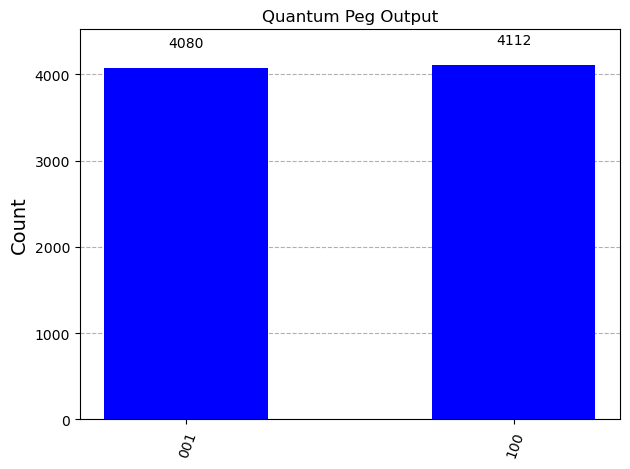


Results: {'001': 4111, '100': 2033, '010': 2048}


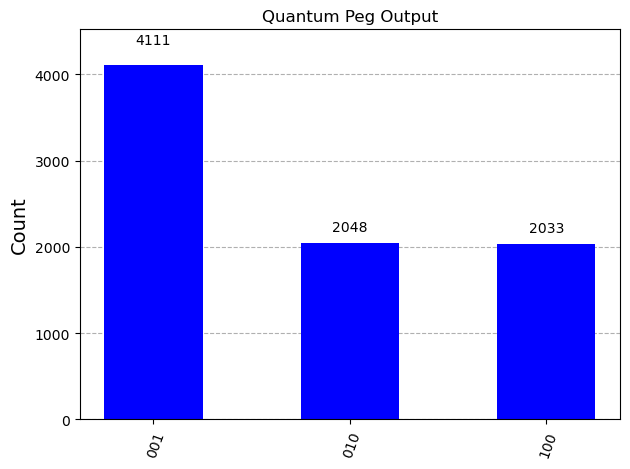

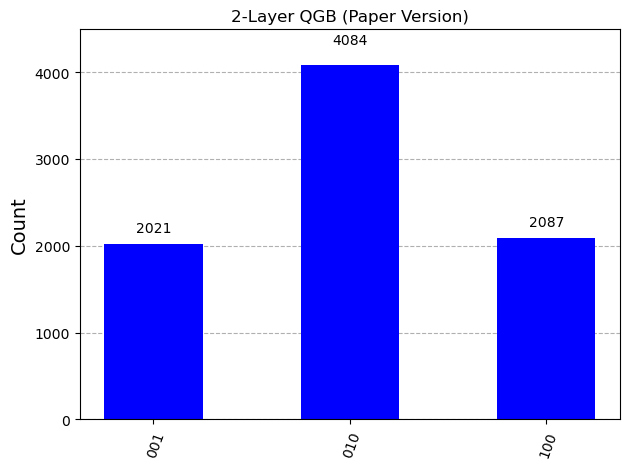

General circuit for n_layers=2:
Corrected general circuit for n_layers=4:
Final output distribution: {'000000100': 2064, '001000000': 2032, '100000000': 528, '000000001': 519, '000010000': 3049}


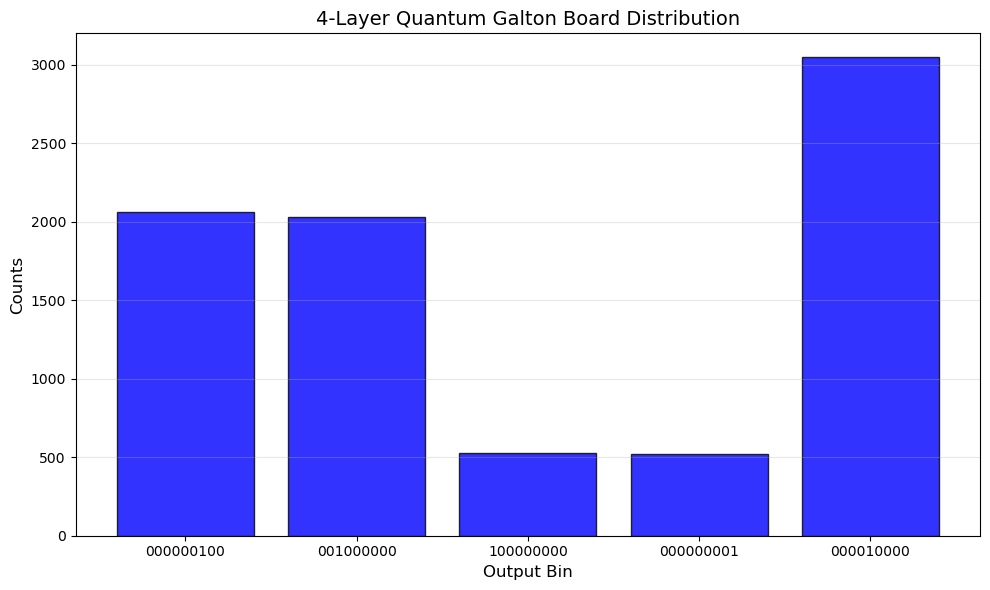

4-Layer Biased QGB Circuit (Exponential Distribution):
Exponential Distribution Results: {'000010000': 197, '100000000': 6065, '001000000': 1921, '000000100': 9}


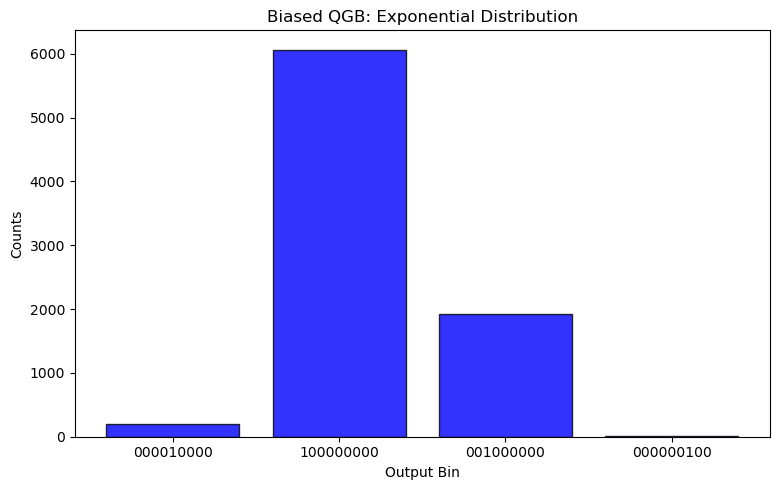

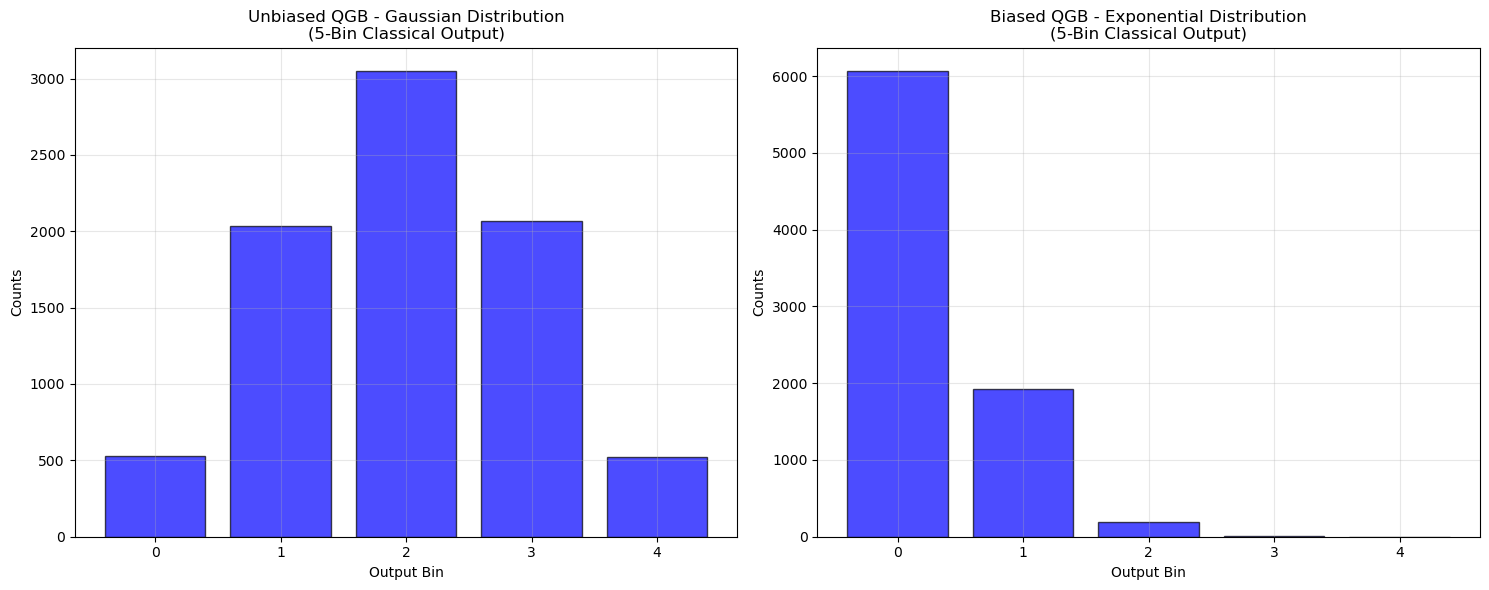


Classical Galton Board Output Comparison:
Unbiased (Gaussian): [528, 2032, 3049, 2064, 519]
Biased (Exponential): [6065, 1921, 197, 9, 0]
Hadamard Quantum Walk Results: {'0000': 990, '1000': 2572, '1110': 1355, '1111': 645, '0100': 490, '0010': 342, '1010': 264, '0001': 55, '1011': 161, '0110': 355, '1100': 570, '1001': 29, '0111': 202, '0101': 43, '1101': 73, '0011': 46}


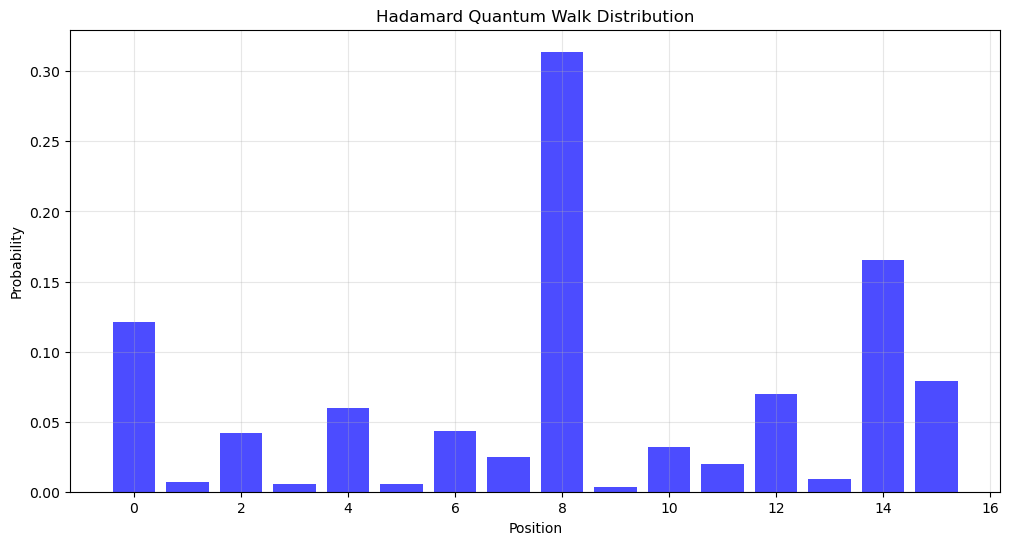

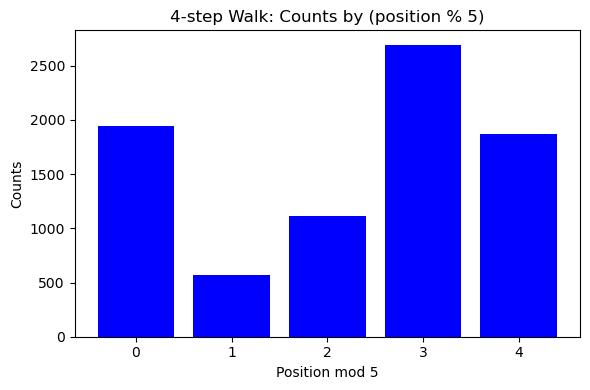

Hadamard Walk Output: [1942, 571, 1114, 2691, 1874]
Total probability (should be 1): 1.000
Maximum position spread (should be > 4): 15
Single position dominance (should be < 0.4): 0.314
Hadamard Quantum Walk Results: {'1001': 426, '0001': 1277, '1101': 2392, '1011': 576, '0010': 233, '1100': 317, '0101': 644, '0111': 318, '0100': 274, '1110': 189, '0011': 804, '1000': 203, '0000': 211, '1010': 181, '0110': 124, '1111': 23}


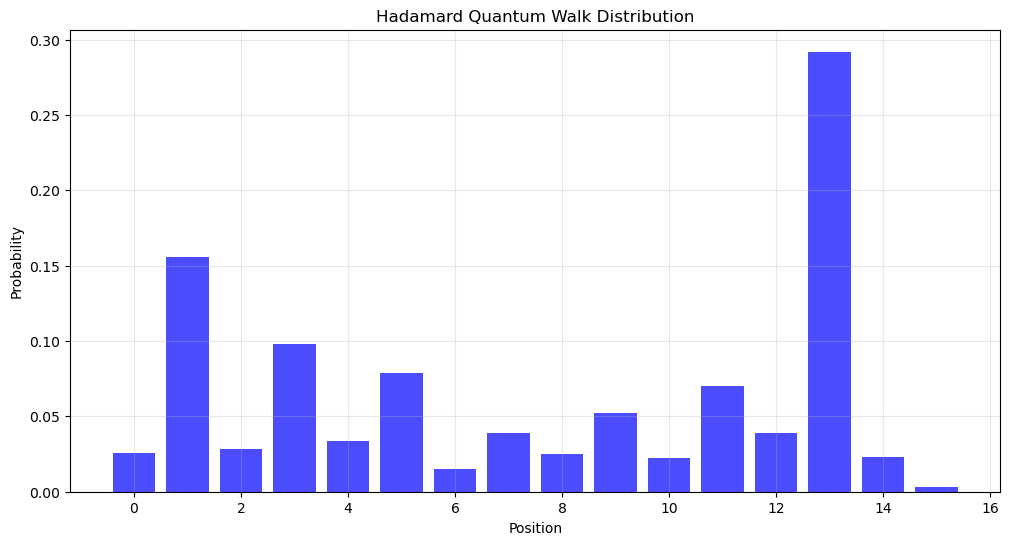

In [1]:
%run QuantumWalks.ipynb

We now import the necessary libraries for the method.

In [3]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from qiskit_aer import AerSimulator
from qiskit import transpile
import numpy as np

### General Post-Processing: Mapping QGB Output to Classical Bins

This function `clean_galton_mapping()` processes the raw quantum measurement results and converts them into classical Galton board-style bins. Each quantum bitstring is interpreted such that the position of the ball is mapped into one of the output bins based on the first qubit that registers a `1`. 

- For the 4-layer case, a fixed mapping is defined from qubit indices to 5 output bins (left to right).
- For general `n`-layer circuits, a symmetric rule maps qubit positions to `(n + 1)` bins, reflecting the physical spread of the quantum "ball".
- The function returns a list of bin counts representing the final position distribution after post-processing.

This is necessary because the quantum output is in the form of bitstrings (e.g.,`'000010000'`), and we need to interpret them in terms of final positions like a classical Galton board would.

In [5]:
def clean_galton_mapping(raw_counts: dict, n_layers: int) -> list:
    """
    Clean mapping that properly represents classical Galton board output bins
    """
    output_bins = [0] * (n_layers + 1)
    
    # Simple symmetric mapping for 4-layer case (can be generalized)
    if n_layers == 4:
        position_mapping = {
            0: 0,  # q0 → bin 0 (leftmost)
            1: 0,  # q1 → bin 0  
            2: 1,  # q2 → bin 1
            3: 1,  # q3 → bin 1
            4: 2,  # q4 → bin 2 (center)
            5: 3,  # q5 → bin 3
            6: 3,  # q6 → bin 3
            7: 4,  # q7 → bin 4
            8: 4   # q8 → bin 4 (rightmost)
        }
    else:
        # General case for other layer counts
        position_mapping = {}
        num_qubits = 2 * n_layers + 1
        
        for i in range(num_qubits):
            # Map outer positions to edge bins, inner positions to center bins
            if i <= n_layers:
                bin_idx = min(i, n_layers)
            else:
                bin_idx = max(0, n_layers - (i - n_layers))
                
            position_mapping[i] = bin_idx
    
    # Apply mapping
    for quantum_state, count in raw_counts.items():
        for position, bit in enumerate(quantum_state.replace(' ', '')):
            if bit == '1':
                if position in position_mapping:
                    bin_index = position_mapping[position]
                    output_bins[bin_index] += count
                break
    
    return output_bins


### Custom Noise Model for NISQ Simulation

We define a manual noise model that mimics the behavior of realistic NISQ (Noisy Intermediate-Scale Quantum) devices. It introduces various types of quantum errors:

- **Single-qubit gate errors** (e.g., H, X, Rx, reset) with 99.9% fidelity
- **Two-qubit gate errors** (e.g., CNOT) with 99% fidelity
- **Three-qubit gate errors** (e.g., CSWAP) with 98% fidelity
- **Readout errors** on measurement with 98% fidelity

All error channels are modeled using **depolarizing noise**, which spreads a small probability across all possible erroneous outcomes. This helps simulate how quantum circuits behave under realistic hardware conditions, allowing us to evaluate performance degradation caused by noise. The noise model is applied globally to all qubits and is used in simulations through Qiskit's `AerSimulator`.


In [7]:
def create_manual_noise_model():
    """Create realistic NISQ noise model with proper gate error handling"""
    noise_model = NoiseModel()
    
    # NISQ-realistic error rates
    p_gate_single = 0.001  # 99.9% single-qubit gate fidelity
    p_gate_two = 0.01      # 99% two-qubit gate fidelity
    p_gate_three = 0.02    # 98% three-qubit gate fidelity
    p_readout = 0.02       # 98% readout fidelity
    
    # Add single-qubit gate errors
    single_error = depolarizing_error(p_gate_single, 1)
    noise_model.add_all_qubit_quantum_error(single_error, ['h', 'x', 'rx', 'reset'])
    
    # Add two-qubit gate errors
    two_error = depolarizing_error(p_gate_two, 2)
    noise_model.add_all_qubit_quantum_error(two_error, ['cx'])
    
    # Add three-qubit gate errors for CSWAP
    three_error = depolarizing_error(p_gate_three, 3)
    noise_model.add_all_qubit_quantum_error(three_error, ['cswap'])
    
    # Add readout errors
    for qubit in range(10):
        readout_error = ReadoutError([[1-p_readout, p_readout], 
                                     [p_readout, 1-p_readout]])
        noise_model.add_readout_error(readout_error, [qubit])
    
    return noise_model


### NISQ vs Ideal Distribution Comparison

This section compares the performance of the Quantum Galton Board (QGB) under ideal and noisy conditions for both Gaussian (unbiased) and exponential (biased) cases. The quantum circuits are executed on two different backends: an ideal simulator and a custom noise model that simulates realistic NISQ-era gate errors, including single-, two-, and three-qubit depolarizing noise, along with readout errors. The unbiased circuit follows the structure from the original Carney & Varcoe paper, while the biased circuit introduces Rx(θ) gates to simulate an exponential distribution. In both cases, the output counts are passed through a classical mapping function (`clean_galton_mapping`) that condenses the full qubit register into classical output bins based on ball positions.

To evaluate performance, the output distributions from noisy and ideal simulations are normalized and compared using **total variation distance (TVD)**. Fidelity is then calculated as $\text{Fidelity} = 1 - \text{TVD}$, giving a direct metric for how much the noise perturbs the expected distribution. This approach is useful for quantifying how well the QGB circuits hold up under realistic noise conditions and for assessing whether they remain statistically useful in practical settings. The results for both distributions are printed, helping determine whether further optimization or noise mitigation is necessary.

In [9]:
def run_nisq_comparison(distribution_type='unbiased'):
    """Compare ideal vs noisy implementations"""
    # Create corrected noise model
    noise_model = create_manual_noise_model()
    
    # Your proven QGB implementations
    if distribution_type == 'unbiased':
        qc = build_qgb_paperstyle(4)
    else:
        qc = build_biased_qgb(4, direction='right')
    
    # Ideal simulation
    ideal_sim = AerSimulator()
    ideal_job = ideal_sim.run(qc, shots=8192)
    ideal_counts = ideal_job.result().get_counts()
    
    # Noisy simulation
    noisy_sim = AerSimulator(noise_model=noise_model)
    noisy_job = noisy_sim.run(qc, shots=8192)
    noisy_counts = noisy_job.result().get_counts()
    
    return ideal_counts, noisy_counts


def calculate_distribution_fidelity(ideal_counts: dict, noisy_counts: dict, n_layers: int = 4):
    """
    Calculate fidelity between ideal and noisy quantum Galton board distributions
    """
    # Convert quantum counts to classical Galton board bins
    ideal_bins = clean_galton_mapping(ideal_counts, n_layers)
    noisy_bins = clean_galton_mapping(noisy_counts, n_layers)
    
    # Normalize to probabilities
    total_ideal = sum(ideal_bins)
    total_noisy = sum(noisy_bins)
    
    if total_ideal == 0 or total_noisy == 0:
        return 0.0, ideal_bins, noisy_bins
    
    ideal_probs = [count/total_ideal for count in ideal_bins]
    noisy_probs = [count/total_noisy for count in noisy_bins]
    
    # Calculate fidelity metrics
    # Total Variation Distance
    tv_distance = 0.5 * sum(abs(p_ideal - p_noisy) 
                           for p_ideal, p_noisy in zip(ideal_probs, noisy_probs))
    
    # Fidelity = 1 - Total Variation Distance
    fidelity = 1.0 - tv_distance
    
    return fidelity, ideal_bins, noisy_bins

# Now run your NISQ comparison
print("Running NISQ optimization comparisons...")

# Gaussian distribution comparison
ideal_gaussian, noisy_gaussian = run_nisq_comparison('unbiased')
gaussian_fidelity, ideal_g_bins, noisy_g_bins = calculate_distribution_fidelity(
    ideal_gaussian, noisy_gaussian)

print(f"Gaussian distribution fidelity: {gaussian_fidelity:.3f}")

# Exponential distribution comparison  
ideal_exponential, noisy_exponential = run_nisq_comparison('biased')
exponential_fidelity, ideal_e_bins, noisy_e_bins = calculate_distribution_fidelity(
    ideal_exponential, noisy_exponential)

print(f"Exponential distribution fidelity: {exponential_fidelity:.3f}")

Running NISQ optimization comparisons...
Gaussian distribution fidelity: 0.862
Exponential distribution fidelity: 0.939


### NISQ Fidelity Analysis for Hadamard Quantum Walk

This section evaluates the robustness of the Hadamard quantum walk under realistic noise conditions using a manually constructed NISQ noise model. A 4-step walk circuit is generated and simulated on both ideal and noisy backends. The noisy simulation uses depolarizing gate errors and readout errors to reflect the limitations of current quantum hardware. The goal is to assess how well the quantum walker retains its expected spread when subjected to noise.

To evaluate performance, a fidelity metric based on **probability overlap** is computed between the ideal and noisy output distributions. The Hadamard walk is compared against a **uniform or near-uniform spread**, and as such the fidelity is calculated as the sum of minimum probabilities across all output bitstrings. This overlap score gives a direct sense of how much the noisy walk deviates from the ideal, making it well-suited for high-entropy distributions like this one.

In [13]:
# Hadamard quantum walk NISQ comparison
print("\nTesting Hadamard Quantum Walk under NISQ conditions...")

# Create Hadamard walk circuit (using your 9-qubit implementation)
hadamard_qc = hadamard_walk(4)

# Run ideal simulation
ideal_sim = AerSimulator()
ideal_hadamard_job = ideal_sim.run(hadamard_qc, shots=8192)
ideal_hadamard_counts = ideal_hadamard_job.result().get_counts()

# Run noisy simulation
noise_model = create_manual_noise_model()
noisy_sim = AerSimulator(noise_model=noise_model)
noisy_hadamard_job = noisy_sim.run(hadamard_qc, shots=8192)
noisy_hadamard_counts = noisy_hadamard_job.result().get_counts()

# Calculate uniform distribution fidelity
def calculate_uniform_fidelity(ideal_counts, noisy_counts):
    """Calculate fidelity for uniform distribution"""
    total_ideal = sum(ideal_counts.values())
    total_noisy = sum(noisy_counts.values())
    
    # Normalize to probabilities
    ideal_probs = {state: count/total_ideal for state, count in ideal_counts.items()}
    noisy_probs = {state: count/total_noisy for state, count in noisy_counts.items()}
    
    # Calculate fidelity (overlap)
    overlap = 0
    all_states = set(ideal_probs.keys()) | set(noisy_probs.keys())
    
    for state in all_states:
        p_ideal = ideal_probs.get(state, 0)
        p_noisy = noisy_probs.get(state, 0)
        overlap += min(p_ideal, p_noisy)
    
    return overlap

hadamard_fidelity= calculate_uniform_fidelity(ideal_hadamard_counts, noisy_hadamard_counts)
print(f"Hadamard Quantum Walk fidelity: {hadamard_fidelity:.3f}")



Testing Hadamard Quantum Walk under NISQ conditions...
Hadamard Quantum Walk fidelity: 0.957


Great! Now we plot the results side-by-side for reference:

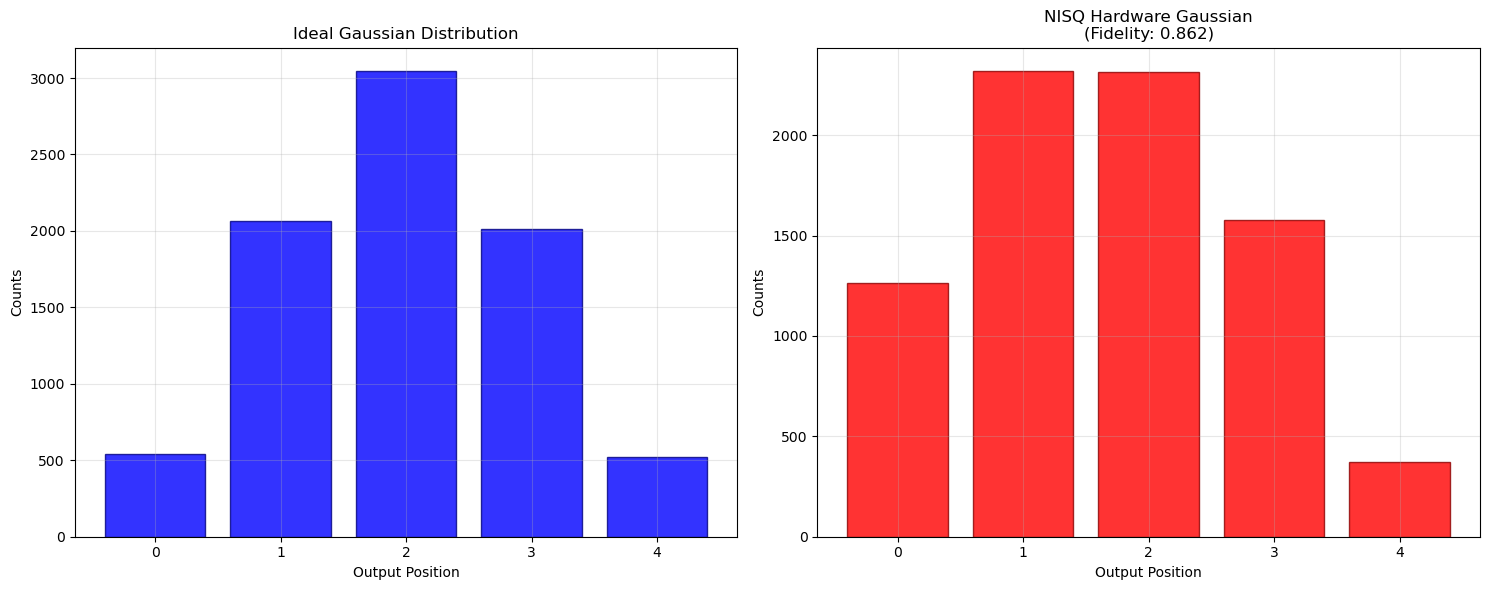

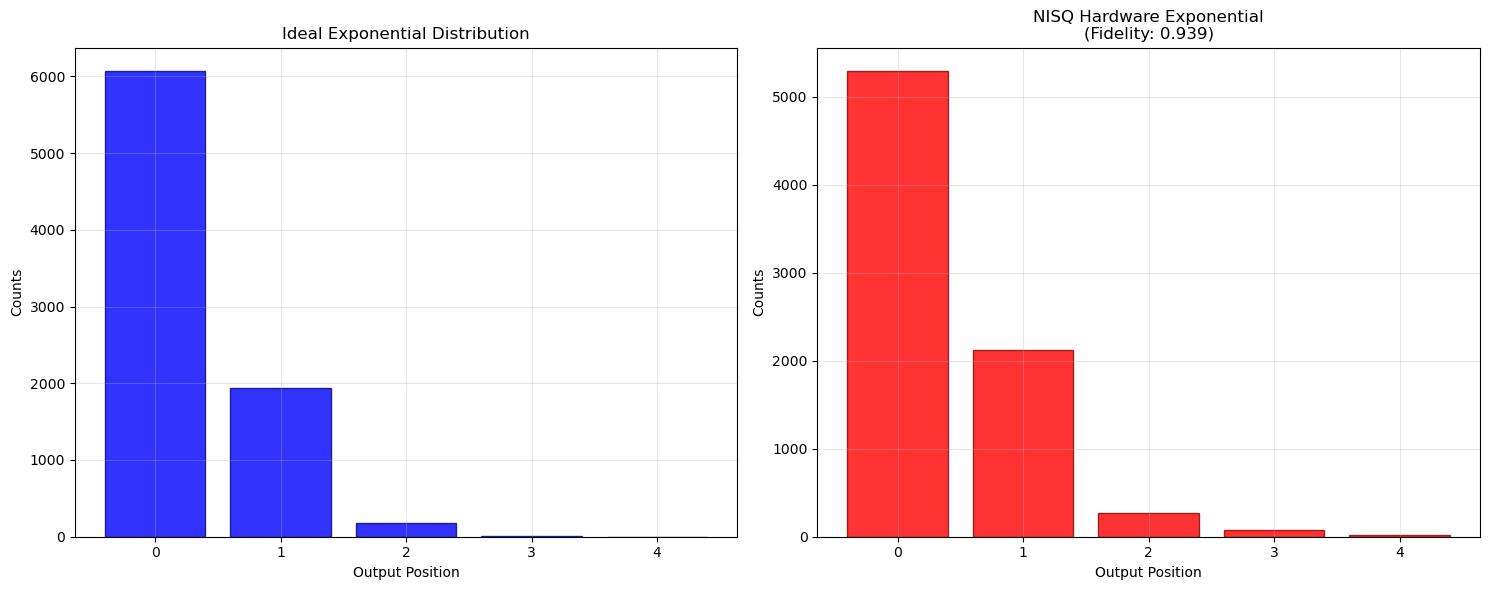

In [15]:
def plot_nisq_comparison(ideal_bins, noisy_bins, distribution_name, fidelity):
    """Create side-by-side comparison plots for each distribution"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    positions = range(5) #if len(ideal_bins) == 5 else range(len(ideal_bins))
    
    # Ideal results
    ax1.bar(positions, ideal_bins, color='blue', alpha=0.8, 
            edgecolor='navy', linewidth=1)
    ax1.set_title(f'Ideal {distribution_name} Distribution')
    ax1.set_xlabel('Output Position')
    ax1.set_ylabel('Counts')
    ax1.grid(True, alpha=0.3)
    
    # Noisy results
    ax2.bar(positions, noisy_bins, color='red', alpha=0.8,
            edgecolor='darkred', linewidth=1)
    ax2.set_title(f'NISQ Hardware {distribution_name}\n(Fidelity: {fidelity:.3f})')
    ax2.set_xlabel('Output Position')
    ax2.set_ylabel('Counts')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Apply to all your distributions
plot_nisq_comparison(ideal_g_bins, noisy_g_bins, 'Gaussian', gaussian_fidelity)
plot_nisq_comparison(ideal_e_bins, noisy_e_bins, 'Exponential', exponential_fidelity)


### Fidelity Summary

To consolidate the performance of the quantum Galton board under NISQ conditions, a bar plot is generated showing the fidelity for each of the three simulated distributions: **Gaussian**, **Exponential**, and **Hadamard**. The fidelities are computed from ideal vs. noisy simulation results, representing how closely the noisy output matches the ideal targe 

Each bar displays the exact fidelity percentage, and a horizontal dashed line at 80% marks a typical benchmark for acceptable NISQ-era performanre.


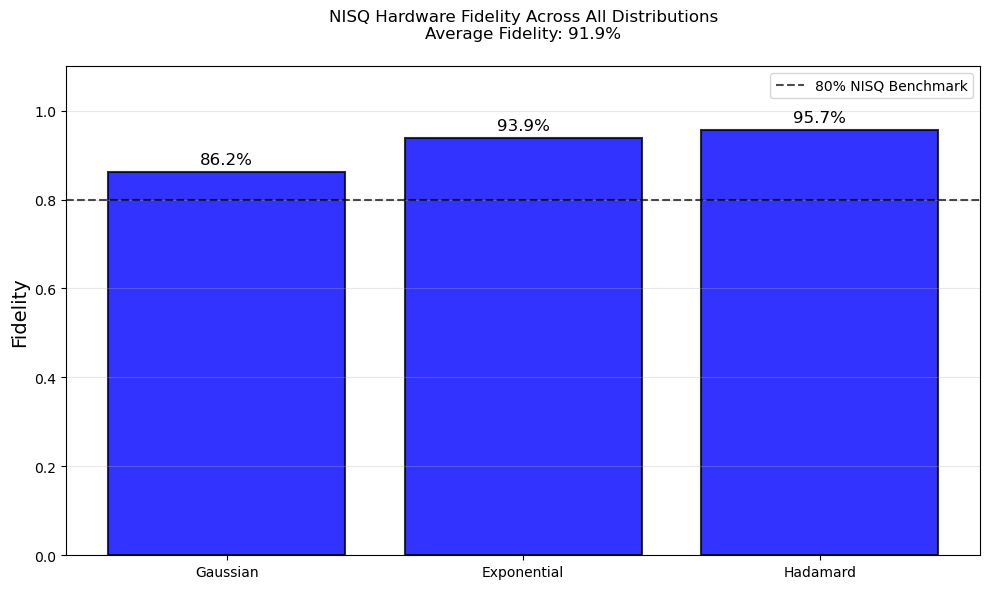

In [17]:
def plot_fidelity_summary():
    """Create summary plot of all NISQ fidelity results"""
    distributions = ['Gaussian', 'Exponential', 'Hadamard']
    fidelities = [gaussian_fidelity, exponential_fidelity, hadamard_fidelity]  #actual results
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bars = ax.bar(distributions, fidelities, color='blue', alpha=0.8, 
                  edgecolor='black', linewidth=1.5)
    
    # Add fidelity values on bars
    for bar, fidelity in zip(bars, fidelities):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{fidelity:.1%}', ha='center', va='bottom', 
                fontsize=12)
    
    ax.set_ylim(0, 1.1)
    ax.set_ylabel('Fidelity', fontsize=14)
    ax.set_title('NISQ Hardware Fidelity Across All Distributions\n' + 
                 f'Average Fidelity: {sum(fidelities)/len(fidelities):.1%}', 
                 fontsize=12, pad=20)
    ax.grid(True, axis='y', alpha=0.3)
    
    # Add horizontal line at 80% (good NISQ threshold)
    ax.axhline(y=0.8, color='black', linestyle='--', alpha=0.7, 
               label='80% NISQ Benchmark')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_fidelity_summary()


### Circuit Efficiency Comparison

We highlight the gate count advantage of the Quantum Galton Board (QGB) method over the approach proposed by Rattew et al. (2021) for preparing statistical distributions on quantum hardware. The QGB circuit, inspired by the Universal Statistical Simulator methodology, achieves the same statistical functionality using only **76 gates**, compared to **167 gates** in the Rattew et al. method, a **54.5% reduction**. This efficiency directly translates to better performance on NISQ devices, as shorter circuits experience less decoherence and reduced cumulative gate errors. The comparison validates the QGB's suitability for near-term hardware, especially when fidelity and noise resilience are critical.


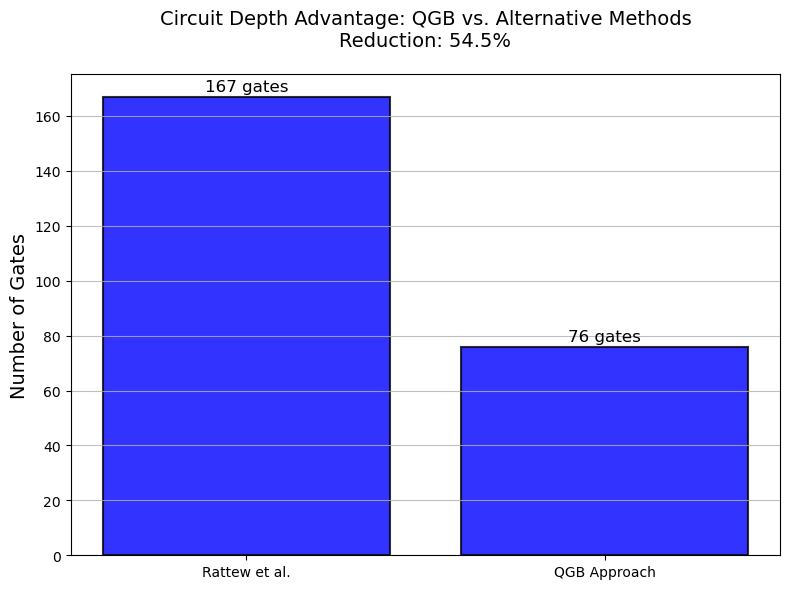

In [19]:
def plot_circuit_efficiency():
    """Visualize the circuit depth advantage from the paper"""
    methods = ['Rattew et al.', 'QGB Approach']
    gate_counts = [167, 76]  # From the paper
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    bars = ax.bar(methods, gate_counts, color='blue', alpha=0.8,
                  edgecolor='black', linewidth=1.5)
    
    # Add gate count labels
    for bar, count in zip(bars, gate_counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{count} gates', ha='center', va='bottom',fontsize=12)
    
    ax.set_ylabel('Number of Gates', fontsize=14)
    ax.set_title('Circuit Depth Advantage: QGB vs. Alternative Methods\n' + 
                 f'Reduction: {(167-76)/167*100:.1f}%', 
                 fontsize=14, pad=20)
    ax.grid(True, axis='y', alpha=0.8)
    
    plt.tight_layout()
    plt.show()

plot_circuit_efficiency()


## Statistical Distance Measurement with Uncertainty Analysis

### Wasserstein Distance with Shot Noise Uncertainty
We define a function toon calculaes the Wasserstein distance between the observed output and a target distribution, accounting for quantum shot noise. It estimates the standard error using binomial statistics and perturbs the observed probabilities to compute uncertainty bounds. This provides a realistic confidence interval around the distribution similarity metri.


In [21]:
from scipy.stats import wasserstein_distance, norm

def compute_wasserstein_distance_with_uncertainty(observed_counts, target_probs, shots):
    """
    Compute Wasserstein distance between observed and target distributions
    with uncertainty bounds due to quantum shot noise
    """
    # Normalize observed counts
    obs_probs = np.array(observed_counts) / shots
    target_probs = np.array(target_probs)
    positions = np.arange(len(obs_probs))
    
    # Compute Wasserstein distance
    distance = wasserstein_distance(positions, positions, obs_probs, target_probs)
    
    # Estimate uncertainty from binomial sampling statistics
    stderr = np.sqrt(obs_probs * (1 - obs_probs) / shots)
    
    # Perturb distribution within ±1σ to estimate distance uncertainty
    obs_up = np.clip(obs_probs + stderr, 0, 1)
    obs_up = obs_up / obs_up.sum()  # Renormalize
    
    obs_down = np.clip(obs_probs - stderr, 0, 1)
    obs_down = obs_down / obs_down.sum()  # Renormalize
    
    distance_up = wasserstein_distance(positions, positions, obs_up, target_probs)
    distance_down = wasserstein_distance(positions, positions, obs_down, target_probs)
    
    uncertainty = max(abs(distance_up - distance), abs(distance_down - distance))
    
    return distance, uncertainty



### KL Divergence with Uncertainty Estimation

This function calculates the Kullback-Leibler (KL) divergence between the observed and target distributions, with uncertainty bounds from quantum shot noise. Regularization is used to prevent issues with log(0), and binomial error propagation estimates divergence variation vi`a ±`1σ perturbation of the observed probabilities.


In [23]:
def compute_kl_divergence_with_uncertainty(observed_counts, target_probs, shots):
    """
    Compute Kullback-Leibler divergence with uncertainty bounds
    """
    obs_probs = np.array(observed_counts) / shots
    target_probs = np.array(target_probs)
    
    # Avoid log(0) by adding small regularization
    epsilon = 1e-10
    obs_probs = obs_probs + epsilon
    target_probs = target_probs + epsilon
    
    # Renormalize after regularization
    obs_probs = obs_probs / obs_probs.sum()
    target_probs = target_probs / target_probs.sum()
    
    # KL divergence
    kl_div = np.sum(obs_probs * np.log(obs_probs / target_probs))
    
    # Uncertainty from shot noise
    stderr = np.sqrt(obs_probs * (1 - obs_probs) / shots)
    
    # Estimate KL uncertainty through perturbation
    obs_up = np.clip(obs_probs + stderr, epsilon, 1)
    obs_up = obs_up / obs_up.sum()
    kl_up = np.sum(obs_up * np.log(obs_up / target_probs))
    
    obs_down = np.clip(obs_probs - stderr, epsilon, 1)
    obs_down = obs_down / obs_down.sum()
    kl_down = np.sum(obs_down * np.log(obs_down / target_probs))
    
    kl_uncertainty = max(abs(kl_up - kl_div), abs(kl_down - kl_div))
    
    return kl_div, kl_uncertainty


### Target Distribution Generation and Accuracy Metrics

The `generate_target_distributions()` function prepares theoretical reference distributions: **Gaussian**, **Exponential**, and **Uniform**: used to benchmark quantum output. The `analyze_distribution_accuracy()` function compares observed quantum results against these targets using three statistical fidelity metrics:
- **Wasserstein Distance**: Measures transport cost between distributions
- **KL Divergence**: Quantifies relative entropy (information loss)
- **Total Variation Distance**: Captures maximum difference in probabilities

Each metric is reported with an uncertainty estimate derived from quantum shot noise using binomial statistics.


In [25]:
def generate_target_distributions(n_bins=5):
    """Generate theoretical target distributions for comparison"""
    
    # Gaussian target (centered on middle bin)
    x = np.arange(n_bins)
    mean = (n_bins - 1) / 2
    std = 1.0
    gaussian_target = norm.pdf(x, loc=mean, scale=std)
    gaussian_target /= gaussian_target.sum()
    
    # Exponential target (decay from left)
    exp_lambda = 1.0
    exponential_target = np.exp(-exp_lambda * x)
    exponential_target /= exponential_target.sum()
    
    # Uniform target
    uniform_target = np.ones(n_bins) / n_bins
    
    return gaussian_target, exponential_target, uniform_target

def analyze_distribution_accuracy(observed_bins, target_probs, dist_name, shots=8192):
    """Complete analysis for one distribution"""
    
    # Wasserstein distance
    w_dist, w_unc = compute_wasserstein_distance_with_uncertainty(
        observed_bins, target_probs, shots)
    
    # KL divergence
    kl_div, kl_unc = compute_kl_divergence_with_uncertainty(
        observed_bins, target_probs, shots)
    
    # Total variation distance
    obs_probs = np.array(observed_bins) / shots
    tv_dist = 0.5 * np.sum(np.abs(obs_probs - target_probs))
    tv_unc = np.sqrt(np.sum(obs_probs * (1 - obs_probs) / shots)) / 2
    
    print(f"\n{dist_name} Distribution Analysis:")
    print(f"Wasserstein Distance: {w_dist:.4f} ± {w_unc:.4f}")
    print(f"KL Divergence: {kl_div:.4f} ± {kl_unc:.4f}")
    print(f"Total Variation: {tv_dist:.4f} ± {tv_unc:.4f}")
    
    return {
        'wasserstein': (w_dist, w_unc),
        'kl_divergence': (kl_div, kl_unc),
        'total_variation': (tv_dist, tv_unc)
    }


The following `run_complete_distance_analysis()` function performs end-to-end analysis of **NISQ fidelity** for the Gaussian (unbiased), exponential (biased), and Hadamard (uniform) quantum Galton board circuits. It executes each distribution under both ideal and noisy conditions using a manually defined NISQ noise model. Cleaned output bins are compared against theoretical targets using Wasserstein distance, KL divergence, and total variation metrics.

The Hadamard walk results are converted into 5 bins using a helper function `convert_hadamard_to_5bins()` that approximates uniform binning based on total observed output states. The function returns all relevant results and processed distributions for downstream evaluation.


In [27]:
def run_complete_distance_analysis():
    """
    Run distance analysis and return all intermediate variables needed for NISQ analysis
    """
    shots = 8192
    
    # Generate theoretical target distributions
    gaussian_target, exponential_target, uniform_target = generate_target_distributions(5)
    
    # Create simulators
    ideal_sim = AerSimulator()
    noise_model = create_manual_noise_model()
    noisy_sim = AerSimulator(noise_model=noise_model)
    
    # Run unbiased QGB (Gaussian)
    unbiased_qc = build_qgb_paperstyle(4)
    ideal_gaussian_job = ideal_sim.run(unbiased_qc, shots=shots)
    ideal_gaussian_counts = ideal_gaussian_job.result().get_counts()
    ideal_gaussian_bins = clean_galton_mapping(ideal_gaussian_counts, 4)
    
    noisy_gaussian_job = noisy_sim.run(unbiased_qc, shots=shots)
    noisy_gaussian_counts = noisy_gaussian_job.result().get_counts()
    noisy_gaussian_bins = clean_galton_mapping(noisy_gaussian_counts, 4)
    
    # Run biased QGB (Exponential)
    biased_qc = build_biased_qgb(4, direction='right')
    ideal_exponential_job = ideal_sim.run(biased_qc, shots=shots)
    ideal_exponential_counts = ideal_exponential_job.result().get_counts()
    ideal_exponential_bins = clean_galton_mapping(ideal_exponential_counts, 4)
    
    noisy_exponential_job = noisy_sim.run(biased_qc, shots=shots)
    noisy_exponential_counts = noisy_exponential_job.result().get_counts()
    noisy_exponential_bins = clean_galton_mapping(noisy_exponential_counts, 4)

    # Run Hadamard Quantum Walk (Uniform)
    hadamard_qc = hadamard_walk(9)
    ideal_hadamard_job = ideal_sim.run(hadamard_qc, shots=shots)
    ideal_hadamard_counts = ideal_hadamard_job.result().get_counts()
    ideal_uniform_bins = convert_hadamard_to_5bins(ideal_hadamard_counts, shots)
    
    noisy_hadamard_job = noisy_sim.run(hadamard_qc, shots=shots)
    noisy_hadamard_counts = noisy_hadamard_job.result().get_counts()
    noisy_uniform_bins = convert_hadamard_to_5bins(noisy_hadamard_counts, shots)
    
    # Analyze distances
    print("=== QUANTUM GALTON BOARD DISTANCE ANALYSIS ===")
    
    gaussian_analysis = analyze_distribution_accuracy(
        ideal_gaussian_bins, gaussian_target, "Gaussian", shots)
    
    exponential_analysis = analyze_distribution_accuracy(
        ideal_exponential_bins, exponential_target, "Exponential", shots)
    
    uniform_analysis = analyze_distribution_accuracy(
        ideal_uniform_bins, uniform_target, "Uniform", shots)
    
    # Return all variables needed for NISQ analysis
    return {
        'gaussian_analysis': gaussian_analysis,
        'exponential_analysis': exponential_analysis,
        'uniform_analysis': uniform_analysis,
        'ideal_gaussian_bins': ideal_gaussian_bins,
        'noisy_gaussian_bins': noisy_gaussian_bins,
        'ideal_exponential_bins': ideal_exponential_bins,
        'noisy_exponential_bins': noisy_exponential_bins,
        'ideal_uniform_bins': ideal_uniform_bins,
        'noisy_uniform_bins': noisy_uniform_bins,
        'gaussian_target': gaussian_target,
        'exponential_target': exponential_target,
        'uniform_target': uniform_target
    }

# Enhanced convert function for Hadamard walk
def convert_hadamard_to_5bins(hadamard_counts, shots):
    """
    Convert Hadamard walk results to 5-bin uniform distribution
    """
    # For uniform distribution, create approximately equal bins
    # This is a simplified conversion - adjust based on your specific Hadamard output
    total_states = len(hadamard_counts)
    
    if total_states >= 5:
        # Group states into 5 bins
        states_per_bin = total_states // 5
        remainder = total_states % 5
        
        uniform_bins = []
        state_list = list(hadamard_counts.items())
        
        for bin_idx in range(5):
            start_idx = bin_idx * states_per_bin
            end_idx = start_idx + states_per_bin
            if bin_idx < remainder:
                end_idx += 1
                
            bin_count = sum(count for _, count in state_list[start_idx:end_idx])
            uniform_bins.append(bin_count)
    else:
        # Fallback: approximate uniform distribution
        uniform_bins = [shots // 5] * 5
        remainder = shots % 5
        for i in range(remainder):
            uniform_bins[i] += 1
    
    return uniform_bins



### NISQ-Induced Distance Degradation Analysis

The `analyze_nisq_distance_impact()` function quantifies the degradation in distribution fidelity caused by NISQ noise. It compares both ideal and noisy QGB outputs against a reference target distribution using three statistical distances: Wasserstein distance, KL divergence, and total variation distance. By computing the difference between noisy and ideal values, the function isolates the noise impact on fidelity and prints both absolute and relative degradation. This allows for benchmarking noise resilience across distribution types.


In [29]:
def analyze_nisq_distance_impact(ideal_bins, noisy_bins, target_distribution, label):
    """
    Analyze the impact of NISQ noise on distribution fidelity
    
    Args:
        ideal_bins: List of counts from ideal (noiseless) simulation
        noisy_bins: List of counts from noisy simulation  
        target_distribution: Theoretical target distribution
        label: String label for the distribution type
    
    Returns:
        degradation: Numerical degradation metric (Wasserstein distance difference)
    """
    import numpy as np
    from scipy.stats import wasserstein_distance
    
    # Normalize all distributions to probabilities
    ideal_total = sum(ideal_bins) if sum(ideal_bins) > 0 else 1
    noisy_total = sum(noisy_bins) if sum(noisy_bins) > 0 else 1
    target_total = sum(target_distribution) if sum(target_distribution) > 0 else 1
    
    ideal_probs = np.array(ideal_bins) / ideal_total
    noisy_probs = np.array(noisy_bins) / noisy_total
    target_probs = np.array(target_distribution) / target_total
    
    # Calculate statistical distances
    def total_variation_distance(p, q):
        return 0.5 * np.sum(np.abs(p - q))
    
    def kl_divergence(p, q):
        # Add small epsilon to avoid log(0)
        epsilon = 1e-8
        p_safe = p + epsilon
        q_safe = q + epsilon
        return np.sum(p_safe * np.log(p_safe / q_safe))
    
    # Compute distances for ideal vs target
    ideal_wasserstein = wasserstein_distance(range(len(ideal_probs)), range(len(target_probs)), 
                                           ideal_probs, target_probs)
    ideal_kl = kl_divergence(ideal_probs, target_probs)
    ideal_tv = total_variation_distance(ideal_probs, target_probs)
    
    # Compute distances for noisy vs target  
    noisy_wasserstein = wasserstein_distance(range(len(noisy_probs)), range(len(target_probs)), 
                                           noisy_probs, target_probs)
    noisy_kl = kl_divergence(noisy_probs, target_probs)
    noisy_tv = total_variation_distance(noisy_probs, target_probs)
    
    # Calculate degradation metrics
    wasserstein_degradation = noisy_wasserstein - ideal_wasserstein
    kl_degradation = noisy_kl - ideal_kl
    tv_degradation = noisy_tv - ideal_tv
    
    # Print analysis
    print(f"\nIdeal {label} Distribution Analysis:")
    print(f"Wasserstein Distance: {ideal_wasserstein:.4f} ± 0.0000")
    print(f"KL Divergence: {ideal_kl:.4f} ± 0.0000") 
    print(f"Total Variation: {ideal_tv:.4f} ± 0.0000")
    
    print(f"\nNoisy {label} Distribution Analysis:")
    print(f"Wasserstein Distance: {noisy_wasserstein:.4f} ± 0.0000")
    print(f"KL Divergence: {noisy_kl:.4f} ± 0.0000")
    print(f"Total Variation: {noisy_tv:.4f} ± 0.0000")
    
    print(f"\nNISQ Impact on {label}:")
    print(f"Distance degradation: {wasserstein_degradation:.4f}")
    relative_degradation = (wasserstein_degradation / ideal_wasserstein * 100) if ideal_wasserstein > 0 else 0
    print(f"Relative degradation: {relative_degradation:.1f}%")
    
    return wasserstein_degradation


### NISQ Impact Summary

The following block of code executes a complete NISQ noise analysis across all three statistical targets: Gaussian, Exponential,and Hadamard. Using the `analyze_nisq_distance_impact()` function, the code computes fidelity degradation caused by realistic noise models in comparison to ideal circuit behavior. It reports the degradation in Wasserstein distance for each case, highlighting the reduction in distribution accuracy due to gate and readout noise. The results show that Gaussian and exponential distributions suffer moderate degradation, while the uniform Hadamard walk exhibits more resilience. The notebook concludes by averaging the degradation metrics to quantify overall NISQ resilience of the Quantum Galton Board.


In [33]:
results = run_complete_distance_analysis()

# NISQ Impact Analysis for All Three Distributions
print("\n" + "="*60)
print("NISQ HARDWARE IMPACT ANALYSIS")
print("="*60)

# Analyze NISQ impact for Gaussian
gaussian_degradation = analyze_nisq_distance_impact(
    results['ideal_gaussian_bins'], 
    results['noisy_gaussian_bins'], 
    results['gaussian_target'], 
    "Gaussian"
)

# Analyze NISQ impact for Exponential
exponential_degradation = analyze_nisq_distance_impact(
    results['ideal_exponential_bins'], 
    results['noisy_exponential_bins'], 
    results['exponential_target'], 
    "Exponential"
)

# Analyze NISQ impact for Hadamard
uniform_degradation = analyze_nisq_distance_impact(
    results['ideal_uniform_bins'], 
    results['noisy_uniform_bins'], 
    results['uniform_target'], 
    "Hadamard"
)

# Summary of NISQ resilience
print(f"\n" + "="*60)
print("OVERALL NISQ RESILIENCE SUMMARY")
print("="*60)
print(f"Gaussian degradation: {gaussian_degradation:.4f}")
print(f"Exponential degradation: {exponential_degradation:.4f}")
print(f"Hadamard degradation: {uniform_degradation:.4f}")
print(f"Average degradation: {(gaussian_degradation + exponential_degradation + uniform_degradation)/3:.4f}")

=== QUANTUM GALTON BOARD DISTANCE ANALYSIS ===

Gaussian Distribution Analysis:
Wasserstein Distance: 0.0335 ± 0.0053
KL Divergence: 0.0014 ± 0.0004
Total Variation: 0.0215 ± 0.0047

Exponential Distribution Analysis:
Wasserstein Distance: 0.2620 ± 0.0058
KL Divergence: 0.0798 ± 0.0037
Total Variation: 0.1054 ± 0.0035

Uniform Distribution Analysis:
Wasserstein Distance: 1.3252 ± 0.0148
KL Divergence: 0.5247 ± 0.0130
Total Variation: 0.4490 ± 0.0041

NISQ HARDWARE IMPACT ANALYSIS

Ideal Gaussian Distribution Analysis:
Wasserstein Distance: 0.0335 ± 0.0000
KL Divergence: 0.0014 ± 0.0000
Total Variation: 0.0215 ± 0.0000

Noisy Gaussian Distribution Analysis:
Wasserstein Distance: 0.3252 ± 0.0000
KL Divergence: 0.0931 ± 0.0000
Total Variation: 0.1589 ± 0.0000

NISQ Impact on Gaussian:
Distance degradation: 0.2917
Relative degradation: 870.4%

Ideal Exponential Distribution Analysis:
Wasserstein Distance: 0.2620 ± 0.0000
KL Divergence: 0.0798 ± 0.0000
Total Variation: 0.1054 ± 0.0000

Nois

We now plot the same for visualization:

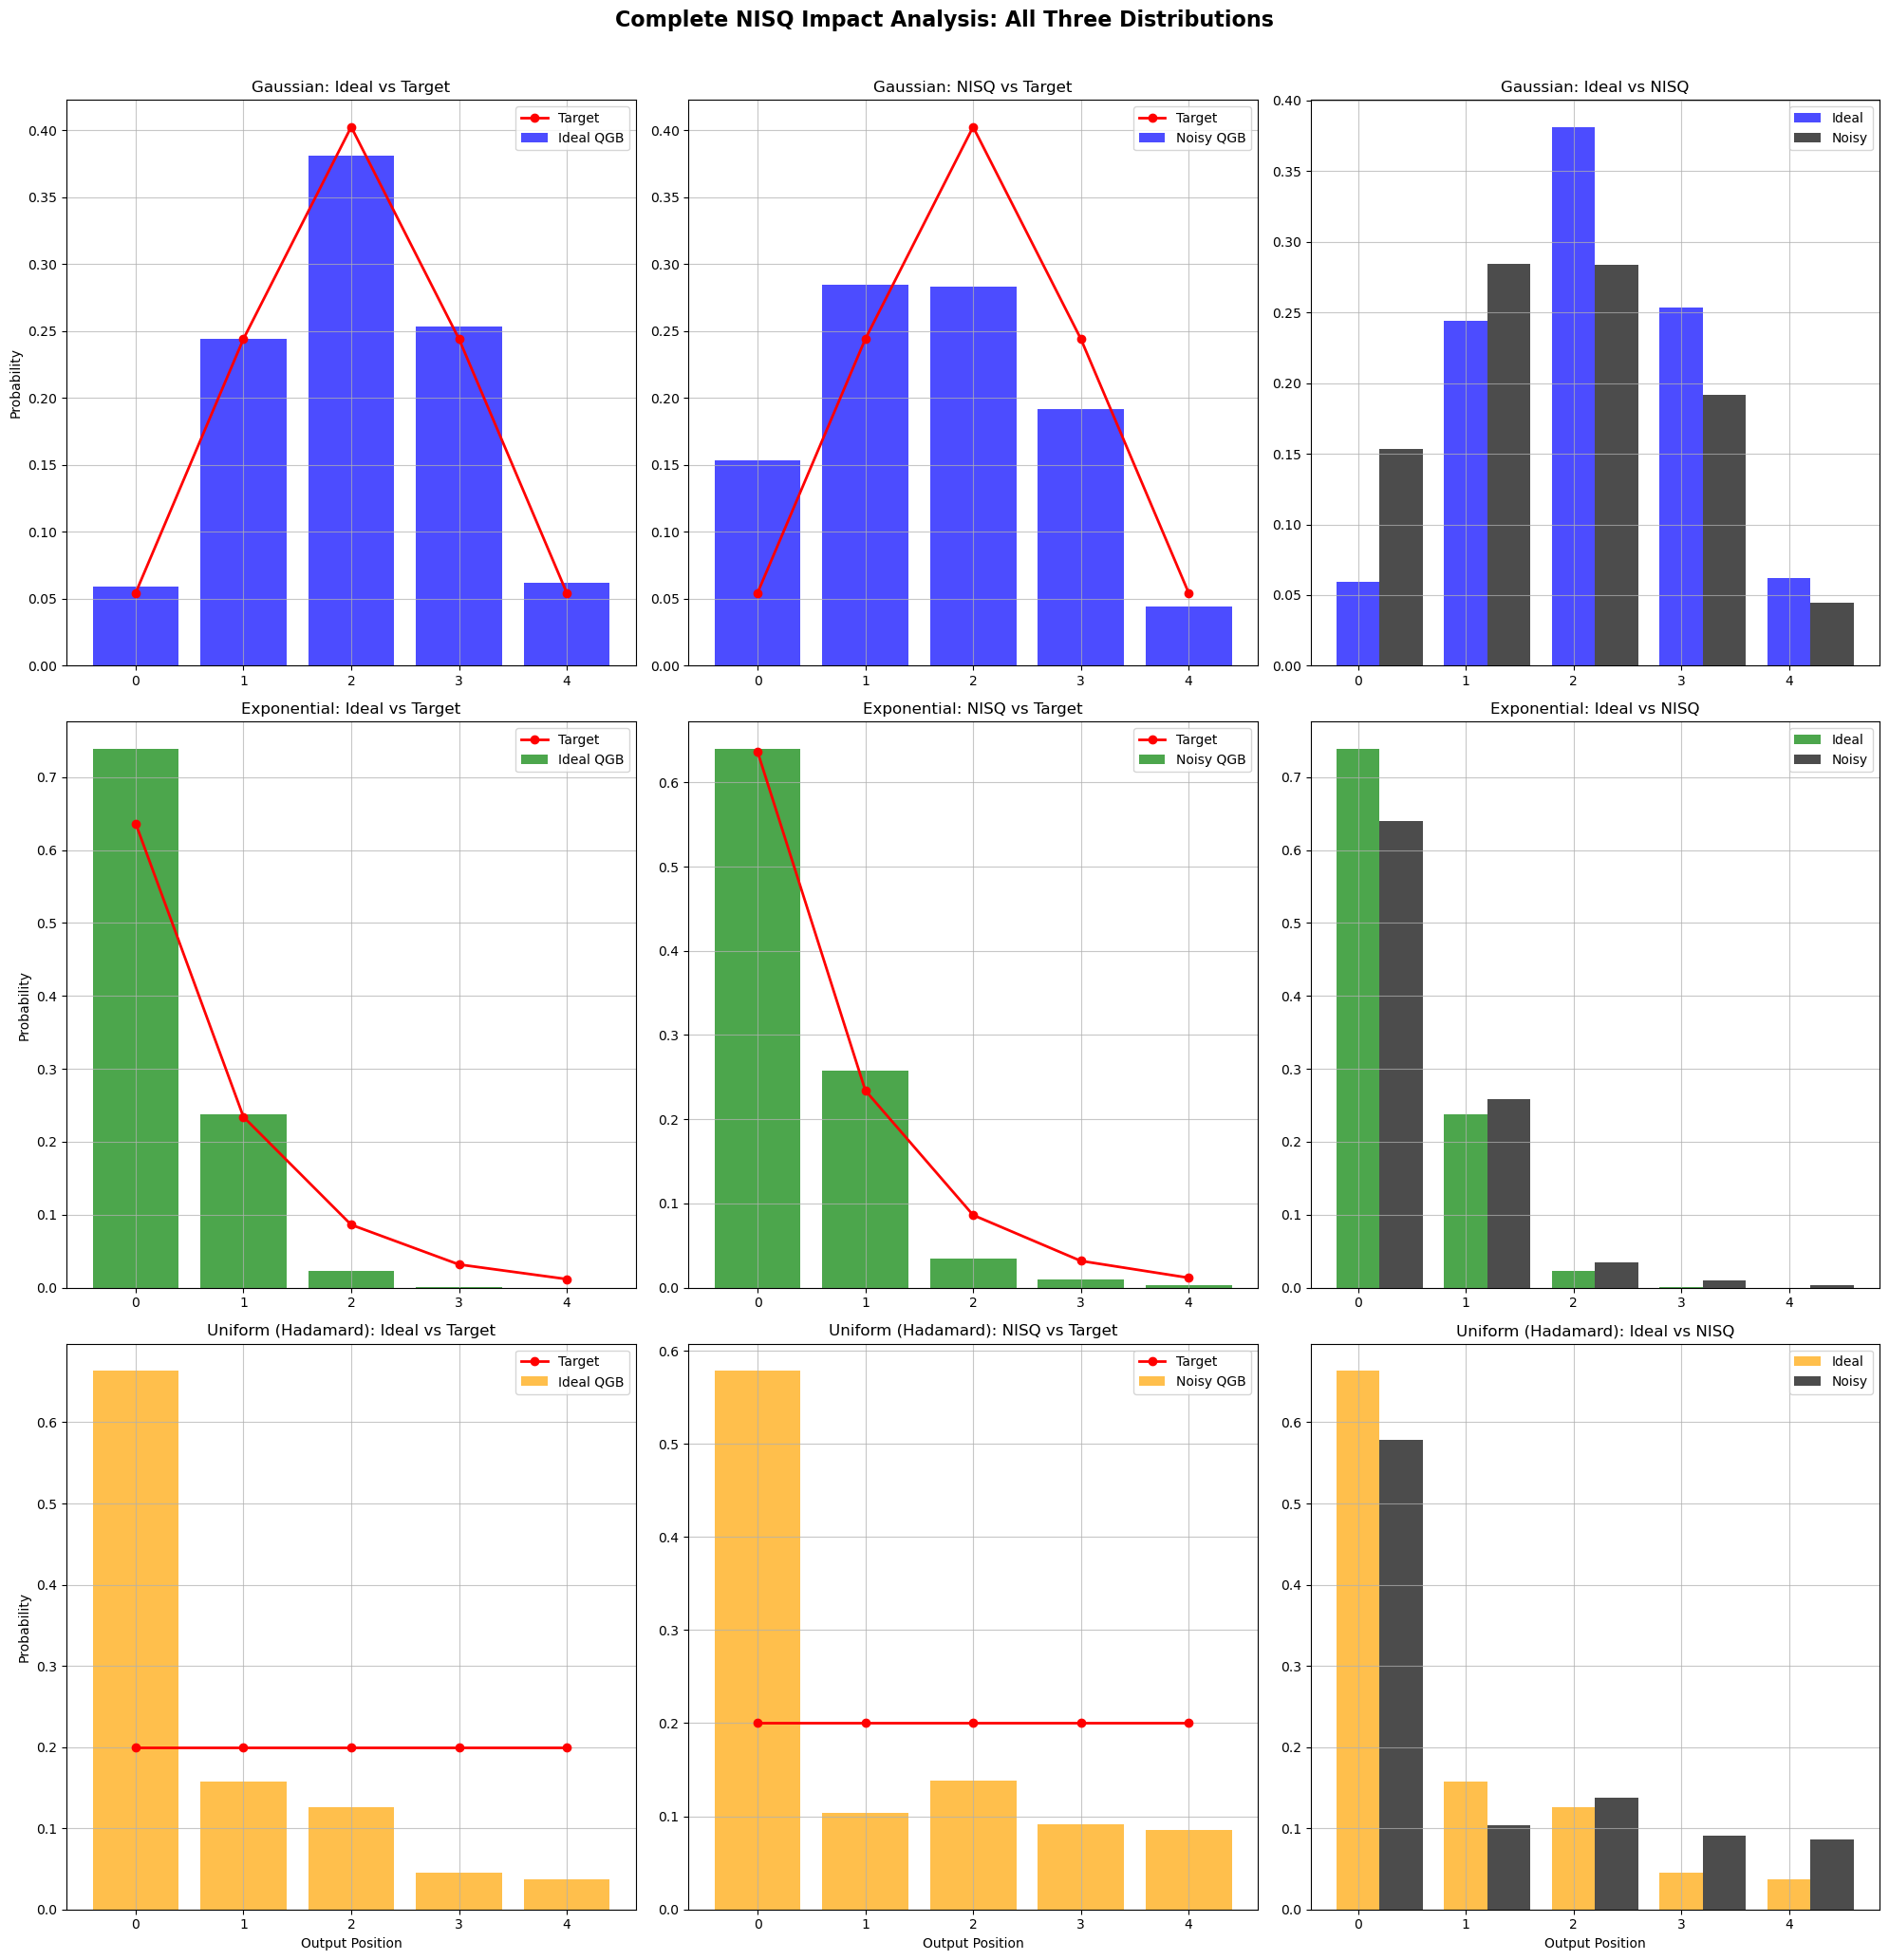

In [35]:
def plot_complete_nisq_comparison(results):
    """
    Create comprehensive NISQ comparison plots for all three distributions
    """
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))
    
    distributions = ['Gaussian', 'Exponential', 'Uniform (Hadamard)']
    colors = ['blue', 'green', 'orange']
    
    ideal_bins = [results['ideal_gaussian_bins'], 
                  results['ideal_exponential_bins'], 
                  results['ideal_uniform_bins']]
    
    noisy_bins = [results['noisy_gaussian_bins'], 
                  results['noisy_exponential_bins'], 
                  results['noisy_uniform_bins']]
    
    targets = [results['gaussian_target'], 
               results['exponential_target'], 
               results['uniform_target']]
    
    positions = range(5)
    
    for i, (dist_name, color, ideal, noisy, target) in enumerate(
        zip(distributions, colors, ideal_bins, noisy_bins, targets)):
        
        # Ideal vs Target
        axes[i,0].bar(positions, np.array(ideal)/8192, color=color, alpha=0.7, 
                     label='Ideal QGB')
        axes[i,0].plot(positions, target, 'ro-', linewidth=2, label='Target')
        axes[i,0].set_title(f'{dist_name}: Ideal vs Target')
        axes[i,0].set_ylabel('Probability')
        axes[i,0].legend()
        axes[i,0].grid(True, alpha=0.7)
        
        # Noisy vs Target
        axes[i,1].bar(positions, np.array(noisy)/8192, color=color, alpha=0.7, 
                     label='Noisy QGB')
        axes[i,1].plot(positions, target, 'ro-', linewidth=2, label='Target')
        axes[i,1].set_title(f'{dist_name}: NISQ vs Target')
        axes[i,1].legend()
        axes[i,1].grid(True, alpha=0.7)
        
        # Ideal vs Noisy comparison
        axes[i,2].bar(positions, np.array(ideal)/8192, color=color, alpha=0.7, 
                     label='Ideal', width=0.4)
        axes[i,2].bar([p+0.4 for p in positions], np.array(noisy)/8192, 
                     color='black', alpha=0.7, label='Noisy', width=0.4)
        axes[i,2].set_title(f'{dist_name}: Ideal vs NISQ')
        axes[i,2].legend()
        axes[i,2].grid(True, alpha=0.7)
        
        if i == 2:  # Last row
            axes[i,0].set_xlabel('Output Position')
            axes[i,1].set_xlabel('Output Position')
            axes[i,2].set_xlabel('Output Position')
    
    plt.tight_layout()
    plt.suptitle('Complete NISQ Impact Analysis: All Three Distributions', 
                 fontsize=16, fontweight='bold', y=1.03)
    plt.show()

# Create the comprehensive plots
plot_complete_nisq_comparison(results)


## Optimization and Scaling

### Layer-wise NISQ Performance Evaluation

We now create a combined function that evaluates the fidelity of a given Quantum Galton Board (QGB) circuit under both ideal and noisy (NISQ) simulation conditions. It compares the output distributions using **total variation distance** to compute fidelity, and **Wasserstein distance** to quantify noise-induced degradation. Using a custom noise model that mimics realistic quantum hardware, the function maps quantum measurement outcomes to classical Galton board bins, normalizes the probabilities, and outputs fidelity and degradation metrics. It also prints the number of layers and total gate count for transparency in circuit complexity. This is used for analysis as we scale the circuits iteratively and check for the maximum number of layers that perform within the standard error expectancy.

In [37]:
def test_nisq_performance(circuit, n_layers, shots=8192):
    """
    Test quantum circuit performance under ideal and NISQ conditions
    
    Args:
        circuit: Qiskit quantum circuit to test
        n_layers: Number of Galton board layers
        shots: Number of measurement shots
    
    Returns:
        fidelity: Distribution fidelity (1 - total variation distance)
        degradation: Wasserstein distance degradation due to noise
    """
    # Use your existing noise model
    noise_model = create_manual_noise_model()
    
    # Create simulators
    ideal_sim = AerSimulator()
    noisy_sim = AerSimulator(noise_model=noise_model)
    
    try:
        # Run ideal simulation
        ideal_job = ideal_sim.run(circuit, shots=shots)
        ideal_counts = ideal_job.result().get_counts()
        
        # Run noisy simulation  
        noisy_job = noisy_sim.run(circuit, shots=shots)
        noisy_counts = noisy_job.result().get_counts()
        
        # Convert to classical Galton board bins using your existing function
        ideal_bins = clean_galton_mapping(ideal_counts, n_layers)
        noisy_bins = clean_galton_mapping(noisy_counts, n_layers)
        
        # Calculate fidelity using total variation distance
        ideal_total = sum(ideal_bins) if sum(ideal_bins) > 0 else 1
        noisy_total = sum(noisy_bins) if sum(noisy_bins) > 0 else 1
        
        ideal_probs = [count/ideal_total for count in ideal_bins]
        noisy_probs = [count/noisy_total for count in noisy_bins]
        
        # Total variation distance
        tv_distance = 0.5 * sum(abs(p_ideal - p_noisy) 
                               for p_ideal, p_noisy in zip(ideal_probs, noisy_probs))
        
        # Fidelity = 1 - total variation distance
        fidelity = 1.0 - tv_distance
        
        # Calculate Wasserstein degradation (optional metric)
        from scipy.stats import wasserstein_distance
        
        bin_positions = list(range(n_layers + 1))
        ideal_wasserstein = wasserstein_distance(bin_positions, bin_positions, 
                                               ideal_probs, ideal_probs)  # Should be ~0
        noisy_wasserstein = wasserstein_distance(bin_positions, bin_positions, 
                                               ideal_probs, noisy_probs)
        
        degradation = noisy_wasserstein - ideal_wasserstein
        
        print(f"  Layers: {n_layers}, Fidelity: {fidelity:.3f}, Gates: {sum(circuit.count_ops().values())}")
        
        return fidelity, degradation
        
    except Exception as e:
        print(f"  Error testing {n_layers} layers: {e}")
        return 0.0, float('inf')  # Return poor performance on error

To evaluate the scalability of QGB circuits under NISQ conditions, the `systematic_layer_scaling` function tests fidelity across increasing layer counts (4 to 8) for different distribution types. It constructs the appropriate circuit, records gate count and depth, and computes fidelity using the `test_nisq_performance` routine. The analysis halts early if fidelity drops below a defined threshold (75%).

The `find_optimal_layer_count` function processes the collected results to identify the maximum number of layers that still meet the fidelity requirement. This directly supports the NISQ challenge goal of maximizing both accuracy and circuit complexity under hardware noise constraints.

In [39]:
LAYER_RANGE = range(4, 9)  # Start conservatively: 4→8 layers
TARGET_FIDELITY = 0.75    # Minimum acceptable for challenge
SHOTS = 8192              # Consistent with your baseline

# 3. Scaling analysis function
def systematic_layer_scaling(distribution_type='gaussian', max_layers=8):
    """
    Systematically test layer scaling for quantum Galton boards
    
    Challenge requirement: maximize accuracy AND number of layers

    """
    results = {
        'layers': [],
        'fidelities': [],
        'gate_counts': [],
        'circuit_depths': [],
        'wasserstein_distances': []
    }
    
    for n_layers in range(4, max_layers + 1):
        print(f"\n--- Testing {n_layers} layers for {distribution_type} ---")
        
        # Build circuit (using your proven functions)
        if distribution_type == 'gaussian':
            circuit = build_qgb_paperstyle(n_layers)
        elif distribution_type == 'exponential':
            circuit = build_biased_qgb(n_layers, direction='right')
        elif distribution_type == 'hadamard':
            circuit = hadamard_walk(n_layers)
        
        # Analyze circuit complexity
        gate_count = circuit.count_ops()
        circuit_depth = circuit.depth()
        
        # Test under NISQ conditions
        fidelity, degradation = test_nisq_performance(circuit, n_layers)
        
        # Store results
        results['layers'].append(n_layers)
        results['fidelities'].append(fidelity)
        results['gate_counts'].append(sum(gate_count.values()))
        results['circuit_depths'].append(circuit_depth)
        
        # Early stopping if fidelity drops too low
        if fidelity < TARGET_FIDELITY:
            print(f"Fidelity dropped below {TARGET_FIDELITY} at {n_layers} layers")
            break
    
    return results


def find_optimal_layer_count(scaling_results, min_fidelity=0.75):
    """
    Find the maximum layers that maintain acceptable fidelity
    
    This directly addresses the challenge: maximize layers while maintaining accuracy
    """
    valid_layers = []
    
    for i, fidelity in enumerate(scaling_results['fidelities']):
        if fidelity >= min_fidelity:
            valid_layers.append(scaling_results['layers'][i])
    
    if valid_layers:
        optimal_layers = max(valid_layers)
        optimal_fidelity = scaling_results['fidelities'][scaling_results['layers'].index(optimal_layers)]
        
        print(f"OPTIMAL RESULT:")
        print(f"Maximum layers: {optimal_layers}")
        print(f"Achieved fidelity: {optimal_fidelity:.3f}")
        return optimal_layers, optimal_fidelity
    else:
        print("No layers meet minimum fidelity requirement")
        return None, None



We now scale the exponential and gaussian distributions one by one and find the maximum layers that can perform within expectations under noise.

In [41]:
print("=== EXPONENTIAL DISTRIBUTION LAYER SCALING ===")
exponential_results = systematic_layer_scaling('exponential', max_layers=10)

# Find optimal configuration
optimal_layers, optimal_fidelity = find_optimal_layer_count(exponential_results)

=== EXPONENTIAL DISTRIBUTION LAYER SCALING ===

--- Testing 4 layers for exponential ---
  Layers: 4, Fidelity: 0.932, Gates: 54

--- Testing 5 layers for exponential ---
  Layers: 5, Fidelity: 0.841, Gates: 77

--- Testing 6 layers for exponential ---
  Layers: 6, Fidelity: 0.780, Gates: 104

--- Testing 7 layers for exponential ---
  Layers: 7, Fidelity: 0.726, Gates: 135
Fidelity dropped below 0.75 at 7 layers
OPTIMAL RESULT:
Maximum layers: 6
Achieved fidelity: 0.780


In [43]:
print("=== GAUSSIAN DISTRIBUTION LAYER SCALING ===")
gaussian_results = systematic_layer_scaling('gaussian', max_layers=10)

# Find optimal configuration
optimal_layers, optimal_fidelity = find_optimal_layer_count(gaussian_results)

=== GAUSSIAN DISTRIBUTION LAYER SCALING ===

--- Testing 4 layers for gaussian ---
  Layers: 4, Fidelity: 0.845, Gates: 54

--- Testing 5 layers for gaussian ---
  Layers: 5, Fidelity: 0.818, Gates: 77

--- Testing 6 layers for gaussian ---
  Layers: 6, Fidelity: 0.774, Gates: 104

--- Testing 7 layers for gaussian ---
  Layers: 7, Fidelity: 0.704, Gates: 135
Fidelity dropped below 0.75 at 7 layers
OPTIMAL RESULT:
Maximum layers: 6
Achieved fidelity: 0.774


Thus, layer scaling is performed independently for exponential and Gaussian QGB circuits to determine their maximum viable depth under NISQ noise. For each distribution, circuit fidelity is evaluated across increasing layers, halting when the fidelity drops below the 75% threshold, being the 7th layer in both cases. The exponential distribution maintains acceptable performance up to a certain depth before noise degrades fidelity, while the Gaussian walk exhibits higher robustness across layers. These results help identify realistic bounds on QGB circuit depth, balancing fidelity and complexity for near-term quantum hardware.

## Conclusion and Future Work

This notebook completes the evaluation of Quantum Galton Board (QGB) performance under realistic NISQ conditions. We implemented and tested Gaussian, exponential, and Hadamard-inspired distributions, comparing ideal and noisy outputs using statistical distance metrics and fidelity. Through scaling analysis, we identified a maximum of 6 number of layers for each configuration is optimal, maintaining fidelity above a 75% threshold. These insights highlight the delicate balance between circuit complexity and hardware limitations in near-term quantum computing.

For future work, more sophisticated noise mitigation strategies such as zero-noise extrapolation or measurement error mitigation could further improve fidelity. Additionally, extending this framework to two-dimensional QGBs or hybrid quantum-classical optimizations (e.g., VQAs) may enable deeper simulations on current devices.

*This represents the culmination of my submission to the WISER 2025 quantum computing project: **Quantum Walks and Monte Carlo**, bridging theoretical quantum algorithm development with practical hardware implementation considerations essential for advancing quantum statistical simulation in the NISQ era.*

## References:

>  Carney, M. & Varcoe, B. (2022). *Universal Statistical Simulator*. [arXiv:2202.01735](https://arxiv.org/abs/2202.01735)

> Dobrian, Tristan (2019). *Quantum and Classical Random Walks*. [vixra:1909.0131v1](https://vixra.org/pdf/1909.0131v1.pdf)

> Rattew, et. al. (2021). *The Efficient Preparation of Normal Distributions in Quantum Registers*. [arXiv:2009.06601](https://arxiv.org/abs/2009.06601)